In [502]:
from matplotlib import pyplot as plt
import numpy as np

import os
import PIL

import random

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [493]:
def get_all_types():
    with open('pokemon_data/pokemon_2.csv', 'r') as pokemon_list:
        types = set()
        
        for line in pokemon_list:
            types.update(set(line.strip().split(',')[1:]))
            
        types.difference_update(['', 'Type1', 'Type2'])
        
    return list(types)

In [494]:
def get_all_data(_type_to_id, _num_types):
    with open('pokemon_data/pokemon_2.csv','r') as pokemon_list:
        output = []
        for line in list(pokemon_list)[1:]: 
            csv_data = line.strip().split(',')
            
            y = torch.zeros(_num_types)
            for types in csv_data[1:]:
                if types != '':
                    y[_type_to_id[types]] = 1
                    
            output.append((csv_data[0], y))
            
    return output[1:]

In [499]:
img_size = 64
batch_size = 100

types = get_all_types()
num_types = len(types)
id_to_type = {i: val for i, val in enumerate(types)}
type_to_id = {val: i for i, val in enumerate(types)}

all_data = get_all_data(type_to_id, num_types)
random.shuffle(all_data)
image_list, type_list = list(zip(*all_data))

image_batch, type_batch = [], []
for i in range(0, len(image_list), batch_size):
    image_batch.append(image_list[i:i+batch_size])
    type_batch.append(type_list[i:i+batch_size])

split1 = round(len(image_batch) * .6)
split2 = split1 + round(len(image_batch) * .2)
train_image, train_type = image_batch[:split1], type_batch[:split1]
test_image, test_type = image_batch[split1:split2], type_batch[split1:split2]
dev_image, dev_type = image_batch[split2:], type_batch[split2:]

num_epochs = 5

In [486]:
def get_image(image_names):
    images = []
    for image_name in image_names:
        image = PIL.Image.open(os.path.join('pokemon_data/images_2', image_name+'.png'))
        if len(image.size) == 2:
            image = image.convert('RGBA')
        images.append(torch.tensor(np.transpose(np.asarray(image.resize((120,120))) / 255.0, (2, 0, 1)))
                      .float()[:3,:,:])
    
    return torch.stack(images)

In [289]:
class PokemonModel(nn.Module):
    def __init__(self):
        super(PokemonModel, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 128, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(128, 256, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(4)
        )
        self.lin = nn.Sequential(
            nn.Linear(256, num_types),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        cnn = self.main(x)
        cnn_flat = torch.reshape(cnn, [-1, 256])
        out = self.lin(cnn_flat)
        
        return out        

In [500]:
model = models.vgg16(pretrained=True)

# Freeze all layers
for p in model.parameters():
    p.requires_grad = False

# Define new classifier layer. This layer will not be frozen
new_classifier = nn.Sequential(
                    nn.Linear(25088, num_types, bias=True),
                    nn.Sigmoid()
                )

model._modules['classifier'] = new_classifier

In [503]:
# model = PokemonModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    for x, y in tqdm(zip(train_image, train_type)):
        img_x = get_image(x).reshape((-1, 3, 120, 120))
        img_y = torch.stack(y)
        model.zero_grad()
        
        output = model.forward(img_x)
        loss = criterion(output, img_y)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        loss = 0
        for x, y in zip(dev_image, dev_type):
            img_x = get_image(x).reshape((-1, 3, 120, 120))
            img_y = torch.stack(y)
            output = model.forward(img_x)
            loss += criterion(output, img_y)
            
        print("Epoch:", epoch+1, "Dev Loss:", loss.item())

47it [02:32,  3.24s/it]


Epoch: 1 Dev Loss: 55.56842803955078


47it [02:22,  3.03s/it]


Epoch: 2 Dev Loss: 54.62202835083008


47it [02:25,  3.09s/it]


Epoch: 3 Dev Loss: 54.08389663696289


47it [02:24,  3.07s/it]


Epoch: 4 Dev Loss: 53.74873352050781


47it [02:25,  3.10s/it]


Epoch: 5 Dev Loss: 53.498809814453125


In [468]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 120, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120, 120 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120 * 2, 120 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120 * 4, 120 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120 * 8, 1, 4, 1, 0, bias=False)
        )
        self.linear = nn.Sequential(
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        cnn = self.main(input)
        return self.linear(torch.flatten(cnn)) 

In [477]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 100, 120 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(120 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(120 * 8, 120 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 120 * 4, 120 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 120 * 2, 120, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120),
            nn.ReLU(True),
            nn.ConvTranspose2d( 120, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [469]:
d = Discriminator()
image = PIL.Image.open(os.path.join('pokemon_data/images', 'abra.png'))
if len(image.size) == 2:
    image = image.convert('RGBA')
im = (torch.tensor(np.transpose(np.asarray(image.resize((120,120))) / 255.0, (2, 0, 1)))
              .float()[:3,:,:])

In [474]:
g = Generator()

noise = torch.randn(1, 100, 1, 1)
fake = g(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


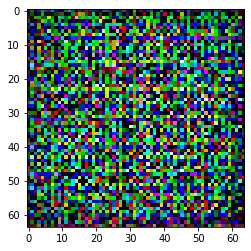

In [482]:
plt.imshow(fake.detach().squeeze().permute((1, 2, 0)))

In [509]:
# Test data

correct_ct = 0
test_image_flat = [i for batch in test_image for i in batch]
test_type_flat = [i for batch in test_type for i in batch]
for x, y in tqdm(zip(test_image_flat, test_type_flat)):
    with torch.no_grad():
        img_x = get_image([x]).reshape((-1, 3, 120, 120))
        img_y = y
        
        output = model.forward(img_x)            
        v, i = output.topk(2)
        type1 = i.squeeze()[0].item()
        type2 = i.squeeze()[1].item() if v.squeeze()[1] > 0.8 else None
        
        if y[type1] == 1:
#             if (type2 and y[type2] == 1) or not type2:
            correct_ct += 1
#                 print(x, id_to_type[type1], id_to_type[type2] if type2 else None)
            
print("Accuracy", correct_ct/len(test_image_flat))

1600it [00:54, 29.21it/s]

Accuracy 0.556875
